In this notebook we tackle the problem of Customer segmentation which plays a crucial rule in modern customer-centric marketing. This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. The dataset is available at <a href="https://archive.ics.uci.edu/ml/datasets/Online+Retail+II">UCI datasets</a>.<br/>

**Contents:**
* 1. Data exploring and preprocessing.
* 2. Feature engineering.
* 3. Modeling.
* 4. Cluster analysis.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, AffinityPropagation, Birch, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

%matplotlib inline
pd.set_option('precision', 2)
sns.set_style('whitegrid')

In [2]:
data = pd.read_excel('online_retail_II.xlsx')

# 1. Data exploring and preprocessing

* Basic data info, number of records and number of variables.

In [3]:
data.shape

(525461, 8)

* Number of different data types in the dataset.

In [4]:
data.dtypes.value_counts()

object            4
float64           2
int64             1
datetime64[ns]    1
dtype: int64

In [5]:
data.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
Invoice        525461 non-null object
StockCode      525461 non-null object
Description    522533 non-null object
Quantity       525461 non-null int64
InvoiceDate    525461 non-null datetime64[ns]
Price          525461 non-null float64
Customer ID    417534 non-null float64
Country        525461 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


* Summary of the number and percentage of missing values in each variable.

In [7]:
# Identify the number of NAs in each feature and select only those having NAs
total_NA = data.isnull().sum()[data.isnull().sum() != 0]

# Calculate the percentage of NA in each feature
percent_NA = data.isnull().sum()[data.isnull().sum() != 0]/data.shape[0]

# Summarize our findings in a dataframe
missing = pd.concat([total_NA, percent_NA], axis=1, keys=['Total NAs', 'Percentage']).sort_values('Total NAs', ascending=False)
missing

Total NAs  Percentage
Customer ID     107927    2.05e-01
Description       2928    5.57e-03

* Transactions with missing Customer IDs are not useful for creating customers segments. So, we drop them.

In [8]:
# Drop transactions with missing Customer ID
data.dropna(axis=0, subset=['Customer ID'], inplace= True)

* Assert that StockCode and Customer ID are of string data type not integers or floats.

In [9]:
data[['StockCode']] = data['StockCode'].astype(str)
data[['Customer ID']] = data['Customer ID'].astype(int).astype(str)

* Generate summary statistics for all categorical variables.

In [61]:
# Summary statistics of categorical variables
data.select_dtypes(include='object').describe().T

count unique                                 top    freq
Invoice           407664  19213                              500356     270
StockCode         407664   4017                              85123A    3153
Description       407664   4444  WHITE HANGING HEART T-LIGHT HOLDER    3153
Customer ID       407664   4312                               14911    5570
Country           407664     37                      United Kingdom  370929
Transaction_date  407664     13                          2010-11-01   60312

* Generate descriptive statistics for the "InvoiceDate" variable.

In [13]:
# Summary statistics of "InvocieDate" variable
data[['InvoiceDate']].describe().T

count unique                 top freq               first  \
InvoiceDate  407664  18008 2010-03-07 15:34:00  270 2009-12-01 07:45:00   

                           last  
InvoiceDate 2010-12-09 20:01:00

* Generate summary statistics for all numerical variables.

In [14]:
# Summary statistics of numeric variables
data.select_dtypes(include= ['int64', 'float64']).describe().transpose()

count   mean    std       min   25%   50%    75%      max
Quantity  407664.0  13.59  96.84  1.00e+00  2.00  5.00  12.00  19152.0
Price     407664.0   3.29  34.76  1.00e-03  1.25  1.95   3.75  10953.5

* Transactions with a letter 'C' at the beginning of its invoice numbers are canceled transactions, so we drop them.

In [10]:
# Drop cancelled transactions
indx = data.Invoice[data.Invoice.str.contains('C') == True].index
data.drop(index= indx, inplace= True)

* Some transaction have a sale price of zero, these could be free gifts for some customers and not true sales transaction. So, we will drop them.

In [11]:
# Drop transactions with price zero
indx = data.loc[data.Price == 0].index
data.drop(index= indx, inplace= True)

# 2. Feature Engineering

We will use the RFM model in addition to two measure to create customer segements. RFM stands for *Recency, Frequency, and Monetary_value*:
* Recency: is a measure of how long it has been since a customer last placed an order with the company.<br/>
* First_purchase: Time in month since the first purchase.<br/>
* Frequency: is a measure of how often a customer orders from the company.<br/>
* Monetary Value: The a mount that a customer spends on an average transaction.<br/>
* Unique_items: is measure of the average number of unique items per transaction. This measure can be used to distinguish between organizational customers and individual customers.

* Calculate the sales amount for each transaction which is the product of sale price and quantity.

In [16]:
# Amount per transaction which is the product of sale price and quantity
data['Amount'] = data['Price'] * data['Quantity']

* Separate transaction time (in hours) from transaction date.

In [17]:
# Create new variable for Invoice time in hours
data['Transaction_time'] = data.InvoiceDate.apply(lambda x : x.time().hour)

In [18]:
# Create new variable for Invoice date
data['Transaction_date'] = data.InvoiceDate.apply(lambda x : x.date())
data['Transaction_date'] = data.Transaction_date.apply(lambda x: x.replace(day = 1))

* For each transaction, calculate the number of months since transaction date to the end of the year (Dec 2010).

In [19]:
# calculate the no. of months since transaction date .
ref = datetime.strptime('2010-12', '%Y-%m')
data['Mnths_since_purchase'] = data.Transaction_date.apply(lambda x: \
                                        relativedelta(ref,x).years*12 + relativedelta(ref,x).months)
Recency = data.groupby('Customer ID').agg({'Mnths_since_purchase' : 'min'}).copy().rename(columns= {'Mnths_since_purchase':'Recency'})

* For each customer, calculate the number of months since his/her first purchase.

In [20]:
# Calculate the number of months since the first purchase for each customer
data['First_purchase'] = data['Mnths_since_purchase'].copy()
First_purchase = data.groupby('Customer ID').agg({'First_purchase' : 'max'}).copy().rename(columns= {'Mnths_since_purchase':'First_purchase'})

* For each customer, calculate the average number of transactions per month (Frequency) and the average purchase amount per month (Monetary value).

In [21]:
# Frequency and Monetary value are computed by first calculating total number of transactions and
# Purchases per month for each customer, then we find the average monthly values for both F & M
F_M = data.groupby(['Customer ID',
                    'Transaction_date']).agg({'Invoice' : 'nunique',
                    'Amount': 'sum'}).groupby(['Customer ID']).agg({'Invoice' : 'mean',
                    'Amount': 'mean'}).copy().rename(columns= {'Invoice':'Frequency',
                                                              'Amount': 'Monetary_value'})

* For each customer, calculate the average number of unique items in each transaction.

In [22]:
# Calculate Average number of unique items in each transaction for each customer
unique_items = data.groupby(['Customer ID', 'Invoice']).agg({'StockCode': 'nunique'}).groupby(['Customer ID']\
            ).agg({'StockCode':'mean'}).rename(columns={'StockCode': 'Unique_items'})

* Assemble all new features into a new data frame to be used for model training later.

In [23]:
# Create transformed data for Clustering
data_transformed = pd.concat([Recency, First_purchase, F_M, unique_items], axis=1)
data_transformed.describe()

Recency  First_purchase  Frequency  Monetary_value  Unique_items
count  4312.00         4312.00    4312.00         4312.00       4312.00
mean      3.17            7.55       1.26          503.98         21.32
std       3.19            3.85       0.69          992.20         17.70
min       0.00            0.00       1.00            2.95          1.00
25%       1.00            4.00       1.00          205.12          9.67
50%       2.00            8.00       1.00          324.66         17.33
75%       5.00           11.00       1.33          510.79         27.00
max      12.00           12.00      19.38        29097.03        220.00

* Plot the distribution for all variables to detect potential outliers and decide whether normalization is needed.

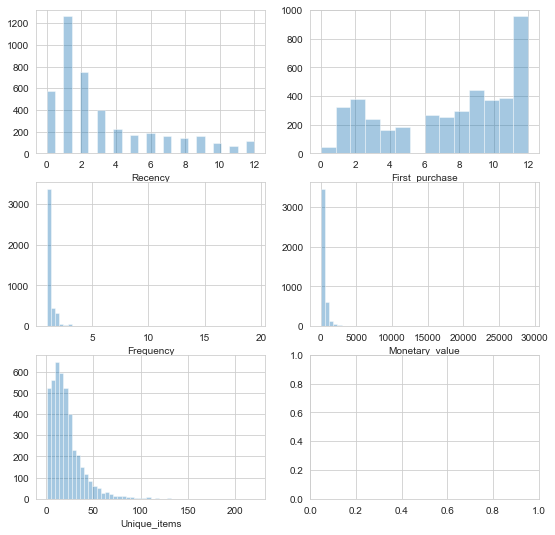

In [24]:
# Plot the distribution of all variables that will be used for model training
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(9,9))
sns.distplot(data_transformed.Recency, ax= ax[0][0], kde= False)
sns.distplot(data_transformed.First_purchase, ax= ax[0][1], kde= False)
sns.distplot(data_transformed.Frequency, ax= ax[1][0], kde= False)
sns.distplot(data_transformed.Monetary_value, ax= ax[1][1], kde= False)
sns.distplot(data_transformed.Unique_items, ax= ax[2][0], kde= False)

The plots show some potential outliers in both frequency and Monetary value, so we will drop those customers from our dataset. Such that customers having more than Mean + 2 Std. will be dropped.

In [25]:
# Define frequency threshold value and drop customers who exceed the threshold
freq_stats = data_transformed['Frequency'].describe()
freq_threshold = freq_stats['mean'] + 2 * freq_stats['std']
indx = data_transformed.loc[data_transformed.Frequency > freq_threshold].index
data_transformed.drop(index = indx, inplace= True)

In [26]:
# Define Monetary value threshold value and drop customers who exceed the threshold
m_stats = data_transformed['Monetary_value'].describe()
m_threshold = m_stats['mean'] + 2 * m_stats['std']
indx = data_transformed.loc[data_transformed.Monetary_value > m_threshold].index
data_transformed.drop(index = indx, inplace= True)

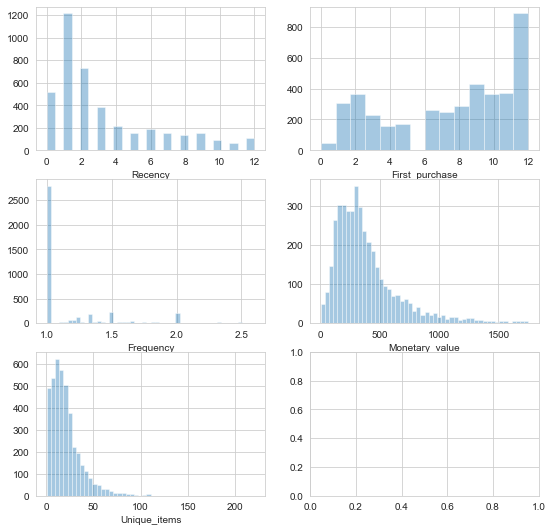

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(9,9))
sns.distplot(data_transformed.Recency, ax= ax[0][0], kde= False)
sns.distplot(data_transformed.First_purchase, ax= ax[0][1], kde= False)
sns.distplot(data_transformed.Frequency, ax= ax[1][0], kde= False)
sns.distplot(data_transformed.Monetary_value, ax= ax[1][1], kde= False)
sns.distplot(data_transformed.Unique_items, ax= ax[2][0], kde= False)

* Plots show that variables have very different scales and some of them are heavily skewed. So we will normalize all variables.

In [28]:
# Normalize the four variables
scaler = pp.StandardScaler()
data_transformed_scaled = pd.DataFrame(scaler.fit_transform(data_transformed),
                                       columns= data_transformed.columns)

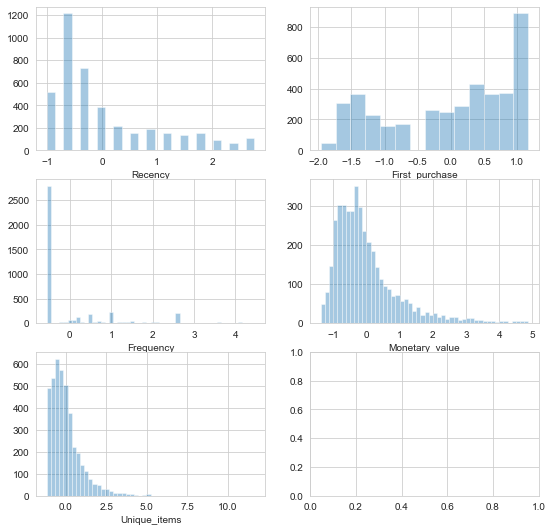

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(9,9))
sns.distplot(data_transformed_scaled.Recency, ax= ax[0][0], kde= False)
sns.distplot(data_transformed_scaled.First_purchase, ax= ax[0][1], kde= False)
sns.distplot(data_transformed_scaled.Frequency, ax= ax[1][0], kde= False)
sns.distplot(data_transformed_scaled.Monetary_value, ax= ax[1][1], kde= False)
sns.distplot(data_transformed_scaled.Unique_items, ax= ax[2][0], kde= False)

# 3. Model training

## 3.1 Trying bunch of candidate models

We will start by trying a bunch of clustering algorithms and select most promising ones. Since the ground truth labels are not known, evaluation will be performed using the model itself. We will use three measures to evaluate clustering models:<br/>
 * Davies Bouldin Score:it signifies the average similarity between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Zero is the lowest possible score. Values closer to zero indicate a better partition.
 * Calinski Harabasz Score (also known as the Variance Ratio Criterion): it is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared). The score is higher when clusters are dense and well separated.
 * Silhouette Score: The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters

In [30]:
# A function to automate the model fiting and prediction
def model_train(estimator, data, a,b):
    db = []
    ca = []
    sc = []
    bic = []
    aic = []
    n_clusters = {'n_clusters':[]}
    if (estimator == AffinityPropagation)|(estimator == DBSCAN)|(estimator == OPTICS)|(estimator==Birch):
        est = estimator()
        est.fit(data)  
        labels = est.labels_
        if np.unique(est.labels_).shape[0] > 1:
            db.append(davies_bouldin_score(data, labels))
            ca.append(calinski_harabasz_score(data, labels))
            sc.append(silhouette_score(data, labels))
            n_clusters['n_clusters'].append('N/A')
        else:
            n_clusters['n_clusters'].append(np.unique(est.labels_).shape[0])
    
    else:
        for k in range(a, b):
            if estimator == GaussianMixture:
                est = estimator(n_components= k)
                labels = est.fit_predict(data)
            else:
                est = estimator(n_clusters= k)
                est.fit(data)
                labels = est.labels_

            db.append(davies_bouldin_score(data, labels))
            ca.append(calinski_harabasz_score(data, labels))
            sc.append(silhouette_score(data, labels))

        n_clusters['n_clusters'].append(np.argmin(db) + a)
        n_clusters['n_clusters'].append(np.argmax(ca) + a)
        n_clusters['n_clusters'].append(np.argmax(sc) + a)
    return db, ca, sc, labels, n_clusters['n_clusters']

In [31]:
#Plot different measures against No. of clusters for algorithms requiring no. of clusters a priori.
def plot_scores(a,b, db, ca, sc):
    fig, ax = plt.subplots(nrows= 1, ncols=3, figsize=(15,4))
    ax[0].plot(range(a, b), db, "bo-", label= 'Davies_Bouldin_Score')
    ax[1].plot(range(a, b), ca, "rx-", label = 'Calinski_Harabasz_Score')
    ax[2].plot(range(a, b), sc, "g.-", label = 'Silhouette_Score')
    ax[0].set_xlabel("$k$", fontsize=14)
    ax[1].set_xlabel("$k$", fontsize=14)
    ax[2].set_xlabel("$k$", fontsize=14)
    ax[0].set_ylabel('Davies Bouldin Score', fontsize=14)
    ax[1].set_ylabel('Calinski Harabasz Score', fontsize=14)
    ax[2].set_ylabel('Silhouette Score', fontsize=14)
#     plt.legend(loc=(1,0),fontsize=14)
    plt.show()

We will try training the following algorithms:<br/>
* KMeans.
* Affinity Propagation.
* Agglomerative hierarchical clustering.
* Birch.
* DBSCAN.
* Gaussian Mixture Model.
* OPTICS.
* Spectral Clustering.

For those algorithms need the number of clusters a priori we will try the range of values between 3 and 7 and select the best model based on evaluation metrics.

In [32]:
clusterers = [KMeans, AffinityPropagation, AgglomerativeClustering, Birch,
             DBSCAN, GaussianMixture, OPTICS, SpectralClustering]

Scores ={'Davies_Bouldin_Score': [], 
         'Calinski_Harabasz_Score': [],
         'Silhouette_Score': [],
        'n_clusters': []}

clusterer_names = ['KMeans', 'Affinity Propagation', 'Agglomerative Clustering', 'Birch',
             'DBSCAN', 'Gaussian Mixture Model', 'OPTICS', 'Spectral Clustering']

for i in clusterers:
    db, ca, sc, labels, n_clusters= model_train(i, data_transformed_scaled, 3, 8)

    Scores['Davies_Bouldin_Score'].append(np.min(db))
    Scores['Calinski_Harabasz_Score'].append(np.max(ca))
    Scores['Silhouette_Score'].append(np.max(sc))
    Scores['n_clusters'].append(n_clusters)

In [33]:
models_scores = pd.DataFrame(Scores, index= clusterer_names)
models_scores

Davies_Bouldin_Score  Calinski_Harabasz_Score  \
KMeans                                    1.14                  1380.05   
Affinity Propagation                      1.17                   399.39   
Agglomerative Clustering                  1.27                  1059.29   
Birch                                     1.35                   693.34   
DBSCAN                                    1.59                    47.63   
Gaussian Mixture Model                    1.93                   621.35   
OPTICS                                    1.28                    10.13   
Spectral Clustering                       1.04                   243.97   

                          Silhouette_Score n_clusters  
KMeans                                0.31  [5, 5, 6]  
Affinity Propagation                  0.20      [N/A]  
Agglomerative Clustering              0.27  [6, 5, 7]  
Birch                                 0.32      [N/A]  
DBSCAN                               -0.32      [N/A]  
Gaussian Mixture Model                0.12  [4, 3, 4]  
OPTICS                               -0.40      [N/A]  
Spectral Clustering                   0.33  [4, 3, 3]

## 3.2 Select a few promising models

* **Best model according to "Davies_Bouldin_Score":**

In [34]:
models_scores.loc[models_scores.Davies_Bouldin_Score == models_scores.Davies_Bouldin_Score.min()]

Davies_Bouldin_Score  Calinski_Harabasz_Score  \
Spectral Clustering                  1.04                   243.97   

                     Silhouette_Score n_clusters  
Spectral Clustering              0.33  [4, 3, 3]

* **Best model according to "Calinski_Harabasz_Score":**

In [35]:
models_scores.loc[models_scores.Calinski_Harabasz_Score == models_scores.Calinski_Harabasz_Score.max()]

Davies_Bouldin_Score  Calinski_Harabasz_Score  Silhouette_Score  \
KMeans                  1.14                  1380.05              0.31   

       n_clusters  
KMeans  [5, 5, 6]

* **Best model according to "Silhouette_Score":**

In [36]:
models_scores.loc[models_scores.Silhouette_Score == models_scores.Silhouette_Score.max()]

Davies_Bouldin_Score  Calinski_Harabasz_Score  \
Spectral Clustering                  1.04                   243.97   

                     Silhouette_Score n_clusters  
Spectral Clustering              0.33  [4, 3, 3]

Now, we have 3 promising models, Spectral clustering with 3, and 4 clusters and Kmeans with 5 clusters. Next, we will find the best model with the best number of clusters that results in clearest interpretation of separation between clusters.

## 3.3 Optimize selected models

In [37]:
def cluster_stats(model, data, data_transformed):
    df = data_transformed.copy()
    df['Cluster'] = pd.Series(model.labels_, name= 'Cluster', index= data_transformed.index)
    df['No._Purchases'] = data.groupby('Customer ID')['Invoice'].count()[df.index]
    df['Total_Amount'] = data.groupby('Customer ID')['Amount'].sum()[df.index]
    cluster_stats = df.groupby('Cluster').agg({'Recency': ['min', 'mean','max'],
                                       'Frequency': ['min', 'mean','max'],
                                       'Monetary_value': ['min', 'mean','max'],
                                       'First_purchase': ['min', 'mean','max'],
                                       'Unique_items': ['min', 'mean','max']}).copy().round(1)
    return cluster_stats, df

In [38]:
def clusters_summary(df, data):
    columns = {'#Customers':[], '#Purchases':[], 'Total_Amount':[]}
    indx =[]
    for i in np.sort(df.Cluster.unique()):
        columns['#Customers'].append(data.iloc[df.loc[df.Cluster == i].index].shape[0])
        columns['#Purchases'].append(df['No._Purchases'].loc[df.Cluster == i].sum())
        columns['Total_Amount'].append(df['Total_Amount'].loc[df.Cluster == i].sum())
        indx.append('Cluster{}'.format(i))
    
    # Synthesis a data frame for cluster summanry
    clusters_summary = pd.DataFrame(data= columns, index = indx)

    clusters_summary['%customers'] = (clusters_summary['#Customers']/df.shape[0])*100
    clusters_summary['%transactions'] = (clusters_summary['#Purchases']/df['No._Purchases'].sum())*100
    clusters_summary['%sales_amount'] = (clusters_summary['Total_Amount']/df['Total_Amount'].sum())*100
    columnsOrder = ['#Customers', '%customers', '#Purchases', '%transactions', 'Total_Amount', '%sales_amount']
    return clusters_summary.reindex(columns=columnsOrder)    

In [39]:
def plot_3d(cluster_stat):
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(cluster_stat['Recency'], cluster_stat['Frequency'], cluster_stat['Monetary_value'],
                     c=cluster_stat['Cluster'], s=60, marker=".",
                         cmap= 'prism', edgecolor= 'k', linewidths= 0.6)
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="center right", title="Customer Segments",
              bbox_to_anchor=(0.75, 0, 0.5, 1), fontsize= 12)
    ax.add_artist(legend1)
    ax.set_xlabel('Recency', fontsize= 12)
    ax.set_ylabel('Frequency', fontsize= 12)
    ax.set_zlabel('Monetary_value', fontsize= 12)

In [66]:
def plot_dist(df, col):
    n= df['Cluster'].nunique()
    mpl.rcParams['figure.figsize'] = (12,12)
    fig, ax = plt.subplots(ncols=2 , nrows= (n//2))
    k = 0
    h=0
    for j in col:
        for i in range(n):
            sns.distplot(df[j][df.Cluster ==i], hist= False, label= 'Cluster{}'.format(i),
                         ax= ax[k][h], kde= True)
        ax[k][h].set_xlabel('{}'.format(j), fontsize= 14)
        h+=1
        if h%2==0:
            h=0
            k +=1

### 1. Spectral Clustering

* Spectral Clustering with 3 Clusters:

In [41]:
specc_3 = SpectralClustering(n_clusters= 3).fit(data_transformed_scaled)

In [42]:
cluster_stats(specc_3, data, data_transformed)[0]

Recency          Frequency           Monetary_value                  \
            min mean max       min mean  max            min    mean     max   
Cluster                                                                       
0             0  3.2  12       1.0  1.1  2.4            3.0   377.2  1751.2   
1             0  1.1   3       2.0  2.0  2.5         1319.7  1604.4  1747.8   
2             0  3.4  12       2.0  2.1  2.6           24.0   533.4  1741.4   

        First_purchase          Unique_items               
                   min mean max          min  mean    max  
Cluster                                                    
0                    0  7.7  12          1.0  21.3  220.0  
1                    1  2.5   5          1.0  26.5   54.4  
2                    0  5.3  12          1.0  17.8   86.0

In [43]:
clusters_summary(cluster_stats(specc_3, data, data_transformed)[1], data)

#Customers  %customers  #Purchases  %transactions  Total_Amount  \
Cluster0        3908       94.79      316754          94.12      5.15e+06   
Cluster1          10        0.24        1042           0.31      3.05e+04   
Cluster2         205        4.97       18729           5.57      2.99e+05   

          %sales_amount  
Cluster0          93.99  
Cluster1           0.56  
Cluster2           5.45

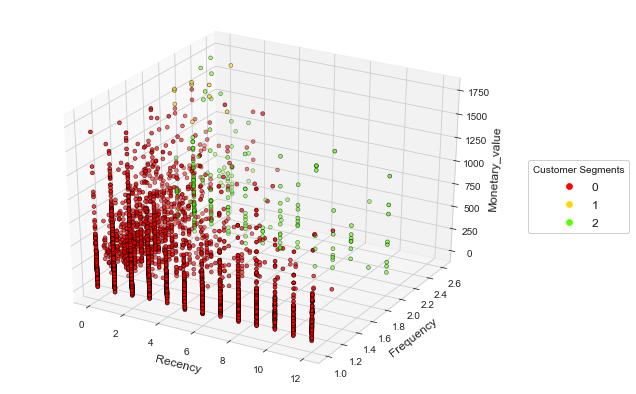

In [44]:
plot_3d(cluster_stats(specc_3, data, data_transformed)[1])

We can see that *Cluster0* alone contains 3424 which is 83.25 of the whole population accounting for 95.14 of the total sales amount! Clearly, this result in not meaning full.<br/>
Let's try Spectral Clustering with 4 clusters!

* Spectral Clustering with 4 clusters:

In [45]:
specc_4 = SpectralClustering(n_clusters= 4).fit(data_transformed_scaled)

In [46]:
cluster_stats(specc_4, data, data_transformed)[0]

Recency          Frequency           Monetary_value                  \
            min mean max       min mean  max            min    mean     max   
Cluster                                                                       
0             0  3.2  12       1.0  1.1  2.5            3.0   378.1  1751.2   
1             0  1.1   3       2.0  2.1  2.5         1470.5  1636.0  1747.8   
2             0  3.5  12       2.0  2.1  2.6           24.0   513.5  1741.4   
3             1  1.3   2       2.0  2.0  2.0         1102.4  1231.8  1319.7   

        First_purchase          Unique_items               
                   min mean max          min  mean    max  
Cluster                                                    
0                    0  7.7  12          1.0  21.3  220.0  
1                    1  2.7   5          1.0  25.0   54.4  
2                    0  5.2  12          1.0  17.5   86.0  
3                    1  1.3   2         39.5  46.8   61.0

In [47]:
clusters_summary(cluster_stats(specc_4, data, data_transformed)[1], data)

#Customers  %customers  #Purchases  %transactions  Total_Amount  \
Cluster0        3912       94.88      318009          94.50      5.19e+06   
Cluster1           9        0.22         963           0.29      2.92e+04   
Cluster2         199        4.83       17268           5.13      2.56e+05   
Cluster3           3        0.07         285           0.08      3.70e+03   

          %sales_amount  
Cluster0          94.73  
Cluster1           0.53  
Cluster2           4.67  
Cluster3           0.07

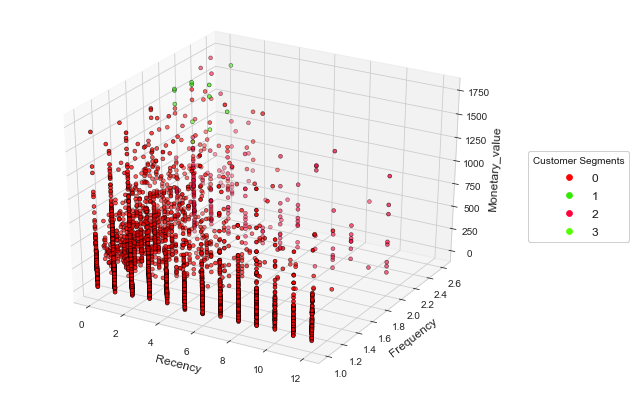

In [48]:
plot_3d(cluster_stats(specc_4, data, data_transformed)[1])

We can see that *Cluster1* alone contains 4034 which is 98.1 of the whole population accounting for 97.37 of the total sales amount! Also, this result in not meaning full.<br/>
Let's try KMeans with 5 clusters!

### 2. KMeans

* KMeans with 5 clusters:

In [49]:
kmeans = KMeans(n_clusters= 5, max_iter= 1000, random_state= 42).fit(data_transformed_scaled)

In [50]:
cluster_stats(kmeans, data, data_transformed)[0]

Recency          Frequency           Monetary_value                 \
            min mean max       min mean  max            min   mean     max   
Cluster                                                                      
0             0  1.6   6       1.0  1.1  1.8           19.5  350.0  1286.0   
1             0  1.9   5       1.0  1.0  1.5            3.8  263.1  1325.0   
2             5  8.5  12       1.0  1.0  2.0            3.0  256.1  1248.5   
3             0  2.5  12       1.0  1.1  2.0          189.4  720.8  1751.2   
4             0  2.0  12       1.0  1.9  2.6           24.0  679.4  1747.8   

        First_purchase           Unique_items               
                   min  mean max          min  mean    max  
Cluster                                                     
0                    6  10.3  12          1.0  18.1   51.8  
1                    0   2.9   7          1.0  16.7   55.0  
2                    6   9.4  12          1.0  15.7   58.0  
3                    0   6.5  12         17.5  56.4  220.0  
4                    0   8.2  12          1.0  18.7   61.0

In [51]:
kmeans_cs = clusters_summary(cluster_stats(kmeans, data, data_transformed)[1], data)
kmeans_cs

#Customers  %customers  #Purchases  %transactions  Total_Amount  \
Cluster0        1278       31.00      126028          37.45      2.08e+06   
Cluster1        1075       26.07       30228           8.98      4.47e+05   
Cluster2         827       20.06       19285           5.73      3.07e+05   
Cluster3         410        9.94       71892          21.36      8.02e+05   
Cluster4         533       12.93       89092          26.47      1.85e+06   

          %sales_amount  
Cluster0          37.91  
Cluster1           8.16  
Cluster2           5.60  
Cluster3          14.63  
Cluster4          33.70

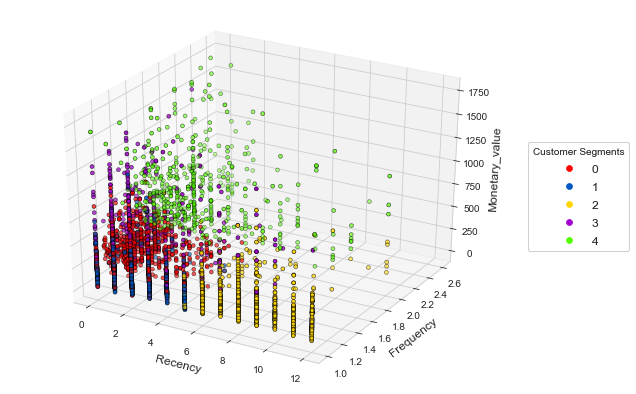

In [52]:
plot_3d(cluster_stats(kmeans, data, data_transformed)[1])

By examining the above summary data frames and figure, we can notice that KMeans actually results in better cluster separation compared to spectral clustering. However, the results doesn't seem very informative and we thick we can get better solution by further model optimization. Hence, we will recheck the best number of clusters for KMeans.

In [53]:
Scores ={'Davies_Bouldin_Score': [], 
         'Calinski_Harabasz_Score': [],
         'Silhouette_Score': []}

for k in range(4,9):
    kmeans = KMeans(n_clusters= k).fit(data_transformed_scaled)
    Scores['Davies_Bouldin_Score'].append(davies_bouldin_score(data_transformed_scaled, 
                                                               kmeans.labels_))
    Scores['Calinski_Harabasz_Score'].append(calinski_harabasz_score(data_transformed_scaled, 
                                                                     kmeans.labels_))
    Scores['Silhouette_Score'].append(silhouette_score(data_transformed_scaled, 
                                                       kmeans.labels_))

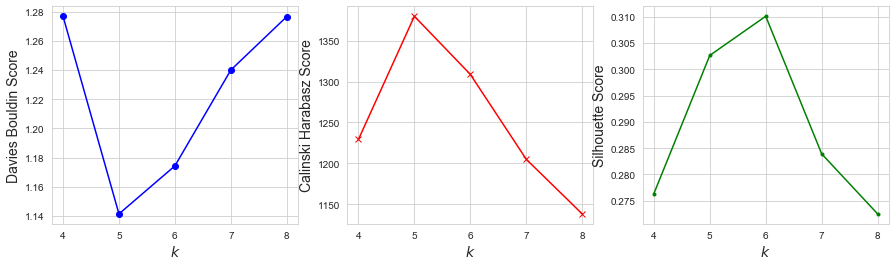

In [54]:
plot_scores(4,9,Scores['Davies_Bouldin_Score'], Scores['Calinski_Harabasz_Score'],
            Scores['Silhouette_Score'])

The plots of different evaluation metrics used at different K values indicates that K=6 can yield a good solution. So, we will examine this solution.

* KMeans with 6 clusters:

In [55]:
kmeans = KMeans(n_clusters= 6, max_iter= 1000, random_state= 42).fit(data_transformed_scaled)

In [56]:
kmeans_results = cluster_stats(kmeans, data, data_transformed)[1]
cluster_stats(kmeans, data, data_transformed)[0]

Recency          Frequency           Monetary_value                  \
            min mean max       min mean  max            min    mean     max   
Cluster                                                                       
0             0  1.6   6       1.0  1.1  1.6           21.6   341.7   853.3   
1             0  1.9   5       1.0  1.0  1.5            3.8   260.4   902.4   
2             5  8.5  12       1.0  1.0  2.0            3.0   252.3   917.7   
3             0  2.5  12       1.0  1.1  2.0          152.6   612.1  1680.5   
4             0  2.0  12       1.0  1.5  2.5          707.6  1126.3  1751.2   
5             0  2.2  12       1.5  1.9  2.6           19.5   474.1  1094.3   

        First_purchase           Unique_items               
                   min  mean max          min  mean    max  
Cluster                                                     
0                    6  10.3  12          1.0  18.3   51.8  
1                    0   2.9   7          1.0  16.3   50.0  
2                    6   9.4  12          1.0  15.9   58.0  
3                    0   5.9  12         29.0  59.2  220.0  
4                    1   9.2  12          1.0  25.0   70.5  
5                    0   7.7  12          1.0  17.0   59.2

In [57]:
kmeans_cs = clusters_summary(cluster_stats(kmeans, data, data_transformed)[1], data)
kmeans_cs

#Customers  %customers  #Purchases  %transactions  Total_Amount  \
Cluster0        1218       29.54      122117          36.29      1.96e+06   
Cluster1        1052       25.52       28854           8.57      4.37e+05   
Cluster2         815       19.77       19059           5.66      2.99e+05   
Cluster3         358        8.68       59861          17.79      5.11e+05   
Cluster4         249        6.04       45501          13.52      1.35e+06   
Cluster5         431       10.45       61133          18.17      9.26e+05   

          %sales_amount  
Cluster0          35.74  
Cluster1           7.98  
Cluster2           5.45  
Cluster3           9.33  
Cluster4          24.61  
Cluster5          16.90

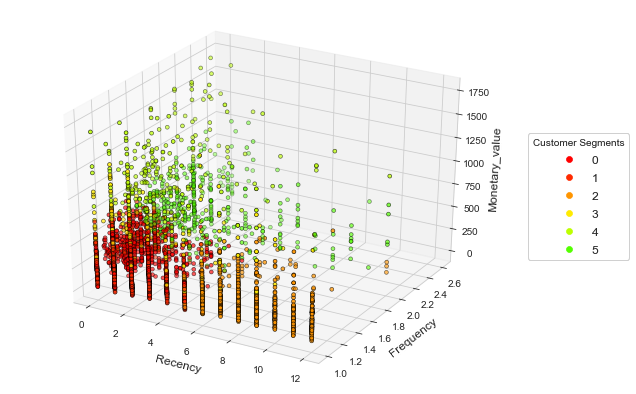

In [58]:
plot_3d(cluster_stats(kmeans, data, data_transformed)[1])

By examining cluster_summary dataframe, cluster_stats dataframe and the scatter plot above , it is interesting to see that each cluster indeed contains a group of consumers that have certain distinct and intrinsic features as detailed below.

# 4. Cluster analysis

Text(0.5, 1.0, 'Proportion of Population')

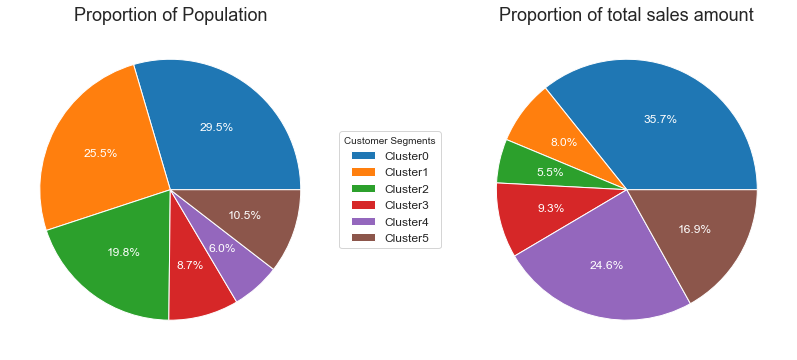

In [59]:
# Two Pie charts to compare clusters in terms of represented population proportion and total sales
# amount proportion
def func(pct):
    return "{:.1f}%".format(pct)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 6), subplot_kw=dict(aspect="equal"))

wedges, text1, autotexts = ax[1].pie(kmeans_cs['%sales_amount'].values,
                                  autopct=lambda pct: func(pct),
                                  textprops=dict(color="w", fontsize= 12))
wedges, text2, autotexts = ax[0].pie(kmeans_cs['%customers'].values,
                                  autopct=lambda pct: func(pct),
                                  textprops=dict(color="w", fontsize= 12))
ax[0].legend(kmeans_cs.index,
          title="Customer Segments",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize= 12)

ax[1].set_title("Proportion of total sales amount", fontsize= 18)
ax[0].set_title("Proportion of Population", fontsize= 18)

*Cluster4* contains 249 customers, composed of 6.04 percent of the whole population. This group seems to be the *most profitable group* as it accounts for 24.6 percent of the total sales amount. Most of the customers in this group have started shopping with the online retailer in the first quarter of the year with an average first_purchase of 9.9, and continued to the end of the year with an average recency of 2 months since last purchase. Also, customers in this group seems to shop frequently during the month with an average frequency of 1.5 transactions per month. Thus, this group can also be categorized as high recency and high frequency.<br/>

In contrast, *Cluster2* includes 815 customers, representing 19.77 of the whole population and accounts for only 5.45 percent of he total sales amount. This group seems to be the least profitable group as none of the customers in this group purchased anything in the last five months of the year. Even for the first seven months of the year, the consumers didn't shop often, and the average value of frequency was only 1 transaction per month. <br/>

*Cluster1* contains 1052 customers, composed of 25.52 percent of the whole population and accounts for 8 percent of the total sales amount. This group includes new customers with an average first_purchase of 2.9 and average recency of 1.9.

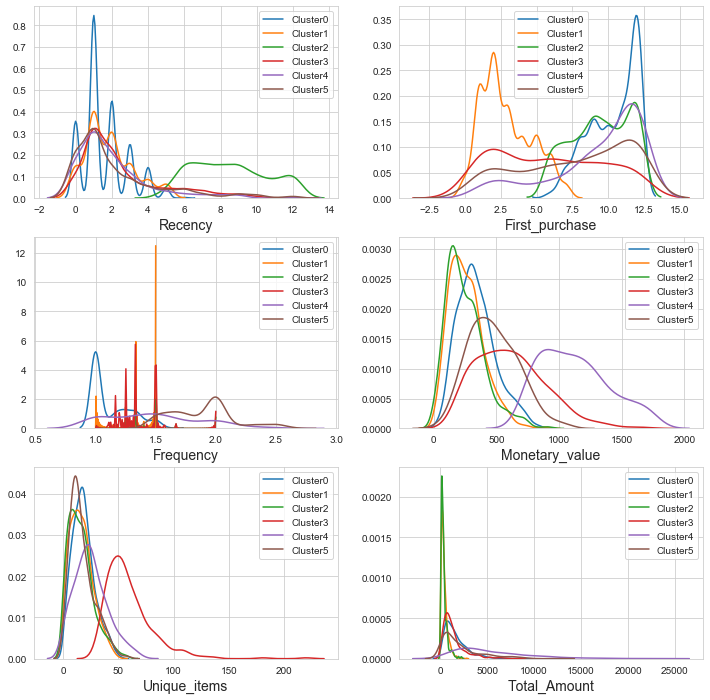

In [67]:
plot_dist(kmeans_results, ['Recency', 'First_purchase', 'Frequency', 'Monetary_value',
                           'Unique_items', 'Total_Amount'])

*Cluster3* contains 358 customers, composing 8.7 percent of the whole population and accounts for 9.3 percent of the total sales. This segment has fairly high profitability with an average monetary_value of £612 per month and moderate frequency with an average 1.1 transaction per month. What is interesting about this cluster is the large average number of unique items in each transaction. This indicates that most of customers in this segment are actually organizational customers not individuals. 

Further, Customers in *Cluster0* are more recent than those in CLuster3. This segment is the largest one, including 35.7 percent of the whole population. This segment includes the loyal customers who started shopping with the online retailer in the first quarter of the year with an average first_purchase of 10.3 and maintained a quite purchase frequency and very high recency with an average of 1.6.<br/>

Finally, *CLuster5* contains about 10.45 percent of the whole population and accounts for 16.9 percent of the total sales amount. Customers in this segment shop frequently with an average frequency of 1.9 transaction per month. They also high monetary-value, £474.1 per month. This segment can be considered as the second most profitable segment.

Now, we can use the resulted clusters to answer the following questions:<br/>
* Who are the most / least valuable customers to the business? What are the distinct characteristics of them?<br/>
* Who are the most / least loyal customers, and how are they characterized?
* What are customers' purchase behavior patterns? Which products / items have customers purchased together often? In which sequence the products have been purchased?
* What are the sales patterns in terms of various perspectives such as products/items, regions and time (weekly, monthly, quarterly, yearly and seasonally), and so on?

*References:<br/>
Chen, D., Sain, S. & Guo, K. J Database Mark Cust Strategy Manag (2012) 19: 197. https://doi.org/10.1057/dbm.2012.17*

*Kumar V., & Werner Reinartz: Customer Relationship Management_Concept, Strategy, and Tools. 10.1007/978-3-662-55381-7*